In [14]:
import os 
import jax
#from two_layer_training import create_data, constant_to_vec, middle_layer_fixed_point, obtain_fixed_point_centre_E
from SSN_classes_phases import SSN2DTopoV1_ONOFF_local
from SSN_classes_jax_on_only import SSN2DTopoV1
import util
from util import take_log, init_set_func
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as np
import numpy
import time

from two_layer_training_lateral_phases import evaluate_model_response, response_matrix, find_bins, bin_response,vmap_evaluate_response
from util import load_param_from_csv, create_stimuli
from pdb import set_trace
from analysis import pre_post_bar_plots, close_far_indices, sort_close_far_EI, plot_close_far


In [2]:
#saving_dir = os.path.join(os.getcwd(), 'results', '04-09', 'test_EIinput', '100_stimuli') #- inhibitory ones close to 
saving_dir = os.path.join(os.getcwd(), 'results', '23-10', 'analysis', 'EI_input_sigma_g0-27')
epoch = 0
ori = 55
E_mid_input_pre = np.load(os.path.join(saving_dir, 'E_mid_'+str(epoch)+'_'+str(ori)+'.npy'))
I_mid_input_pre = np.load(os.path.join(saving_dir, 'I_mid_'+str(epoch)+'_'+str(ori)+'.npy'))
E_sup_input_pre = np.load(os.path.join(saving_dir, 'E_sup_'+str(epoch)+'_'+str(ori)+'.npy'))
I_sup_input_pre = np.load(os.path.join(saving_dir, 'I_sup_'+str(epoch)+'_'+str(ori)+'.npy'))


epoch = 989
E_mid_input_post =np.load(os.path.join(saving_dir, 'E_mid_'+str(epoch)+'_'+str(ori)+'.npy'))
I_mid_input_post = np.load(os.path.join(saving_dir, 'I_mid_'+str(epoch)+'_'+str(ori)+'.npy'))
E_sup_input_post = np.load(os.path.join(saving_dir, 'E_sup_'+str(epoch)+'_'+str(ori)+'.npy'))
I_sup_input_post= np.load(os.path.join(saving_dir, 'I_sup_'+str(epoch)+'_'+str(ori)+'.npy'))


In [3]:
E_mid_indices = np.where(np.abs(E_mid_input_post)>np.abs(E_mid_input_pre))[0]
E_sup_indices = np.where(np.abs(E_sup_input_post)>np.abs(E_sup_input_pre))[0]
I_mid_indices = np.where(np.abs(I_mid_input_post)>np.abs(I_mid_input_pre))[0]
I_sup_indices = np.where(np.abs(I_sup_input_post)>np.abs(I_sup_input_pre))[0]

In [4]:
less_I_sup_indices = np.where(np.abs(I_sup_input_post)<np.abs(I_sup_input_pre))[0]
less_I_sup_indices

DeviceArray([ 29,  51, 132], dtype=int32)

In [5]:
len(I_sup_indices)

159

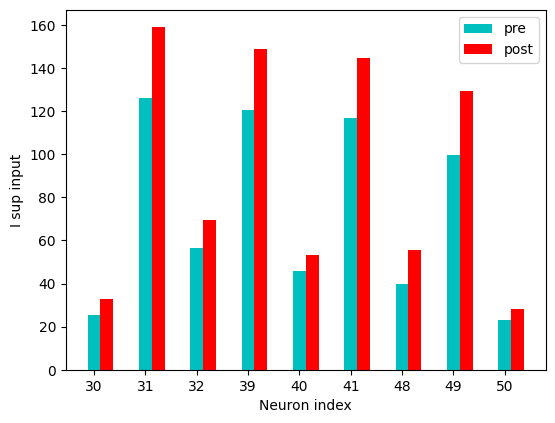

In [6]:
#neuron_index = np.asarray([30, 31, 32, 33, 40])
centre_indices = np.asarray([ 30,  31,  32,  39, 40, 41, 48, 49, 50 ])#,  82,  91, 101, 107, 111, 113, 114, 116, 121, 141, 142, 144, 146, 147, 149, 153, 157,158])]
pre_post_bar_plots(centre_indices, pre_vec = I_sup_input_pre, post_vec = I_sup_input_post, yaxis = 'I sup input', saving_dir = saving_dir)

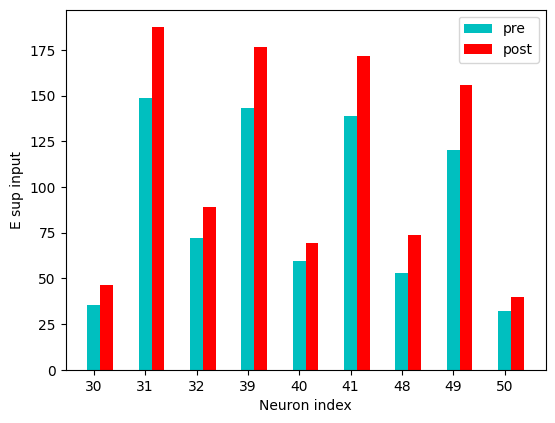

In [8]:
pre_post_bar_plots(centre_indices, pre_vec = E_sup_input_pre, post_vec = E_sup_input_post, saving_dir = saving_dir, yaxis = 'E sup input')

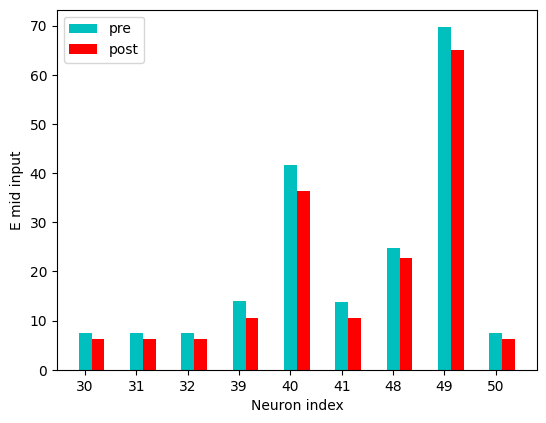

In [9]:
#centre_indices = np.asarray([ 30,  31,  32,  39, 40, 41 ])
pre_post_bar_plots(centre_indices, pre_vec = E_mid_input_pre, post_vec = E_mid_input_post, yaxis = 'E mid input', saving_dir = saving_dir)

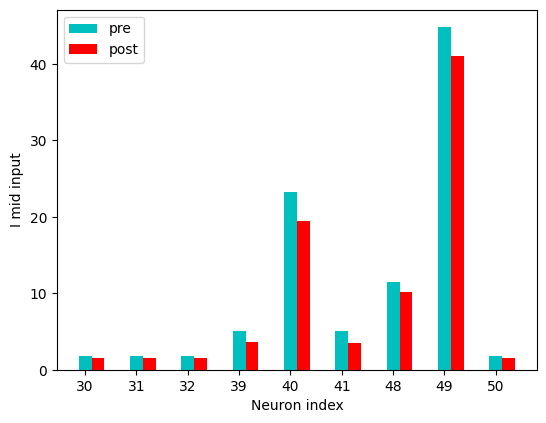

In [10]:
#centre_indices = np.asarray([ 30,  31,  32,  39, 40, 41 ])
pre_post_bar_plots(centre_indices, pre_vec = I_mid_input_pre, post_vec = I_mid_input_post, yaxis = 'I mid input', saving_dir = saving_dir)

In [12]:
plt.hist(ssn_sup.ori_vec[less_I_sup_indices])
plt.xlabel('Orientation')
plt.ylabel('Frequency')
plt.title('Orientation of neurons where I input decreases')
#plt.savefig('/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/23-10/analysis/EI_input/histI_decrease.png')
plt.show()

NameError: name 'ssn_sup' is not defined

In [17]:
saving_dir

'/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/23-10/analysis/EI_input_sigma_g0-27'

In [23]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 4

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0)#, jitter_val = 5)
stimuli_pars.update(general_pars)

#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 20 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    A2 = None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    phases = 2
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.4 # mm   
    sigma_RF = 0.4 # deg (visual angle)

class conn_pars_m():
    PERIODIC = False
    p_local = None

    
class conn_pars_s():
    PERIODIC = False
    p_local = None

        
class filter_pars():
    sigma_g = np.array(0.27)
    conv_factor = numpy.array(2)
    k = numpy.array(1)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    
    
class conv_pars:
    dt = 1
    xtol = 1e-03
    Tmax = 400
    verbose = False
    silent = True
    Rmax_E = None
    Rmax_I= None

class loss_pars:
    lambda_dx = 1
    lambda_r_max = 1
    lambda_w = 1
    lambda_b = 1
    
sigma_oris = np.asarray([[90.0, 90.0], [90.0, 90.0]])
ssn_ori_map_loaded = np.load(os.path.join(os.getcwd(), 'orientation_maps', 'map_1.npy'))
    
init_set_m ='C'
init_set_s=1
_, s_2x2_s, gE_s, gI_s, conn_pars_s  = init_set_func(init_set_s, conn_pars_s, ssn_pars)
_, _, gE_m, gI_m, conn_pars_m  = init_set_func(init_set_m, conn_pars_m, ssn_pars, middle = True)
gE = [gE_m, gE_s]
gI = [gI_m, gI_s]

results_filename = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/23-10/phases_4k_1sigma_g0.27gE_0.3/set_C_sig_noise_2.0_batch50_lamw1_results.csv'
epoch = 989

[J_2x2_m, J_2x2_s, c_E, c_I, f_E, f_I, kappa_pre, kappa_post] = load_param_from_csv(results_filename = results_filename, epoch = epoch)

#Initialise SSN layers
#ssn_mid=SSN2DTopoV1_ONOFF_local(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_m, filter_pars=filter_pars, J_2x2=J_2x2_m, gE = gE_m, gI=gI_m)
#ssn_sup=SSN2DTopoV1(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_s, filter_pars=filter_pars, J_2x2=J_2x2_s, s_2x2=s_2x2_s, gE = gE_s, gI=gI_s, sigma_oris = sigma_oris, kappa_pre = kappa_pre, kappa_post = kappa_post, ori_map = ssn_mid.ori_map, train_ori = 55)

In [ ]:
ssn_sup.make_new_W(J_2x2_s, sigma_

In [20]:
ssn_sup.W

DeviceArray([[ 4.2653260e+00,  3.9333627e-02,  8.1716035e-04, ...,
              -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
             [ 3.9333627e-02,  4.2653260e+00,  3.7574824e-02, ...,
              -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
             [ 8.1716035e-04,  3.7574824e-02,  4.2653260e+00, ...,
              -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
             ...,
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -1.2416493e+00, -0.0000000e+00, -0.0000000e+00],
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -0.0000000e+00, -1.2416493e+00, -0.0000000e+00],
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -0.0000000e+00, -0.0000000e+00, -1.2416493e+00]],            dtype=float32)

In [13]:
kappa = np.asarray(0)
kappa.shape

()

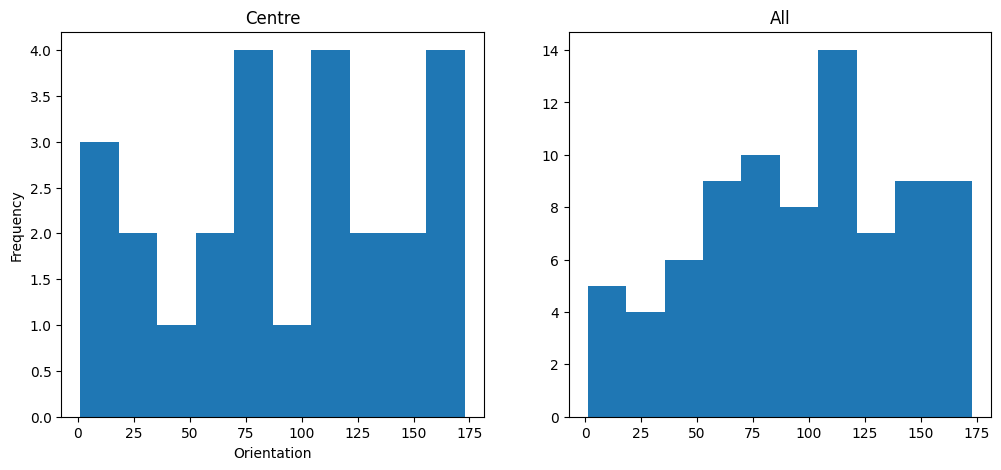

In [57]:
save = False
fig, axs = plt.subplots(1,2, figsize = (12,5))
#Centre neurons
axs[0].hist(ssn_sup.ori_map[2:7, 2:7].ravel())
axs[1].hist(ssn_sup.ori_map.ravel())
axs[0].set_xlabel('Orientation')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Centre')
axs[1].set_title('All')

if save:
    index+=1
    plt.savefig(os.path.join(os.getcwd(), 'orientation_maps', 'map_'+str(index)+'_hist.png'))
plt.show()

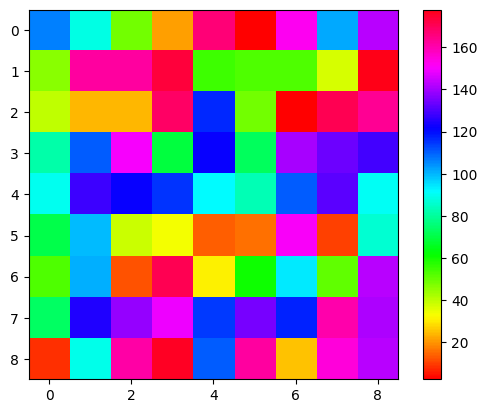

In [362]:
plt.imshow(ssn_sup.ori_map, cmap = 'hsv')
plt.colorbar()

save = False
if save == True:
    index+=1
    plt.savefig(os.path.join(os.getcwd(), 'orientation_maps',  'map_'+str(index)+'.png'))
    np.save( os.path.join(os.getcwd(), 'orientation_maps', 'map_'+str(index)+'.npy'), ssn_sup.ori_map)
    np.save( os.path.join(os.getcwd(), 'orientation_maps', 'ori_vec_'+str(index)+'.npy'), ssn_mid.ori_vec)

In [8]:
#weights 1
ssn_sup.ori_vec[np.asarray([centre_indices])]

DeviceArray([[169.94534  ,  53.43352  ,  98.38569  ,  56.464752 ,
              100.44589  ,  51.538414 ,   0.7327632,  30.685328 ,
              168.72075  ]], dtype=float32)

In [9]:
#weights 2
ssn_sup.ori_vec[np.asarray([ 91,  96, 107, 111, 113, 114, 121, 141, 142, 144, 149, 153,
              157, 158])]

DeviceArray([ 22.59708 , 155.1902  , 140.01825 , 169.94534 ,  98.38569 ,
             147.01447 , 100.44589 ,  34.54265 ,  30.258701, 117.52367 ,
             173.12619 ,  70.964294,  70.91225 ,  90.90606 ],            dtype=float32)

In [10]:
#Sort out neuron indices according to type and orientation
e_close_mid, e_far_mid, i_close_mid, i_far_mid = sort_close_far_EI(ssn_mid, train_ori =55)
e_close_sup, e_far_sup, i_close_sup, i_far_sup= sort_close_far_EI(ssn_sup, train_ori =55)

100.0
100.0


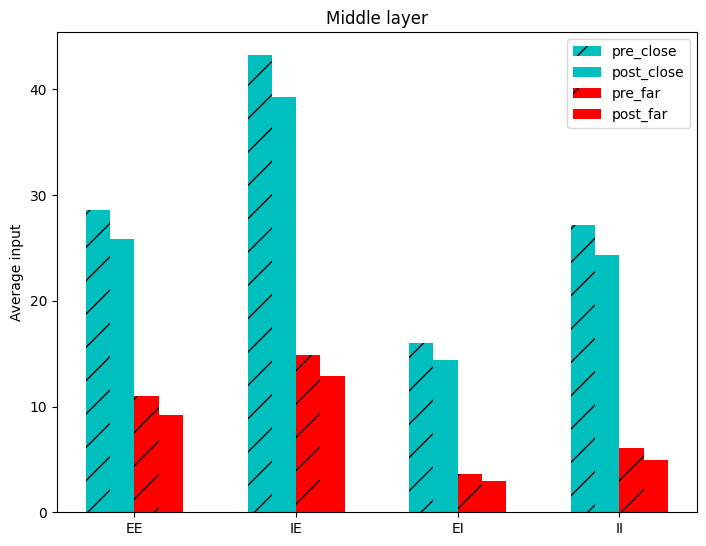

In [12]:
save = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/04-09/lateral/E_Iinput'
save = None
plot_close_far(E_mid_input_pre, E_mid_input_post, I_mid_input_pre, I_mid_input_post, e_close_mid, e_far_mid, i_close_mid, i_far_mid, save = saving_dir, title='Middle layer')

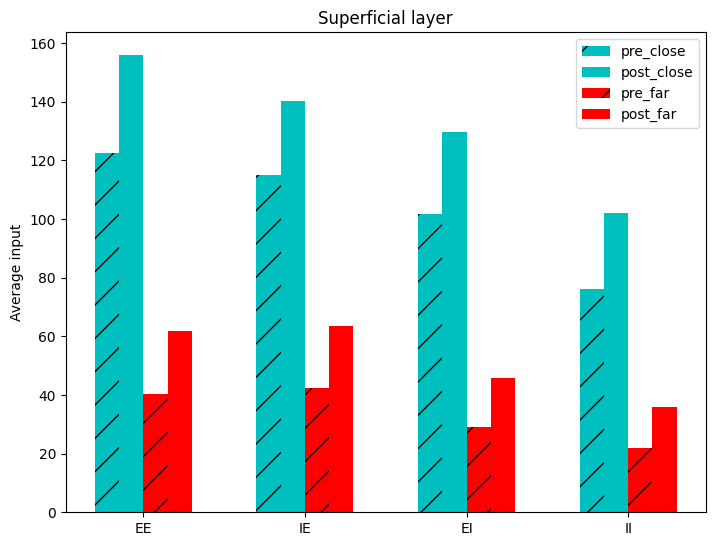

In [10]:
plot_close_far(E_sup_input_pre, E_sup_input_post, I_sup_input_pre, I_sup_input_post, e_close_sup, e_far_sup, i_close_sup, i_far_sup, save = None, title = 'Superficial layer')

In [26]:
from analysis import param_ratios_two_layer
results_filename = os.path.join(os.getcwd(), 'results', '30-10', 'freeze_pars', 'phases_4k_1sigma_g0.27gE_0.3', 'set_C_sig_noise_2.0_batch50_lamw1_results.csv')
leaky_results = os.path.join(os.getcwd(), 'results', '30-10', 'freeze_pars', '0-15_leaky_phases_4k_1sigma_g0.27gE_0.3', 'set_C_sig_noise_2.0_batch50_lamw1_results.csv')

In [27]:
param_ratios_two_layer(results_filename)

939 Int64Index([96], dtype='int64')
J_m ratios =  [[-6.679442   1.7600875 -3.1822398  5.7706075]]
J_s ratios =  [[ -8.585145   8.397468 -10.514174  24.333313]]
kappas =  [[-0.11484986  0.29698917  0.05849833  0.29698917]]


In [31]:
param_ratios_two_layer(leaky_results, percent_acc=0.8)

1007 Int64Index([103], dtype='int64')
J_m ratios =  [[-12.390734    12.065822     1.4645337    0.86180997]]
J_s ratios =  [[-4.868433   0.7181471 -5.4518275 19.564478 ]]
kappas =  [[-0.02241075  0.26956698  0.10047914  0.26956698]]


In [ ]:
results = pd.read_csv(results_file, header = 0)